In [201]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import keras.optimizers as optimizers
import optuna

from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.backend import clear_session

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [5]:
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [3]:
from tensorflow import keras

In [218]:
btc_df = pd.read_csv('BTCData.csv')
eth_df = pd.read_csv('ETHData.csv')
xrp_df = pd.read_csv('XRPData.csv')

In [104]:
btc_df.describe()

,Price
count,1461.000000
mean,22658.744764
std,18094.447310
min,3228.700000
25%,8145.700000
50%,11753.500000
75%,38709.700000
max,67527.900000


In [219]:
btc_df = btc_df.replace(',','', regex=True)
btc_df = btc_df[['Price', 'Date']]
btc_df['Date']= pd.to_datetime(btc_df['Date'])
btc_df = btc_df.set_index("Date")
btc_df['Price'] = pd.to_numeric(btc_df['Price'],errors='coerce')


eth_df = eth_df.replace(',','', regex=True)
eth_df = eth_df[['Price', 'Date']]
eth_df['Date']= pd.to_datetime(eth_df['Date'])
eth_df = eth_df.set_index("Date")
eth_df['Price'] = pd.to_numeric(eth_df['Price'],errors='coerce')


xrp_df = xrp_df.replace(',','', regex=True)
xrp_df = xrp_df[['Price', 'Date']]
xrp_df['Date']= pd.to_datetime(xrp_df['Date'])
xrp_df = xrp_df.set_index("Date")
xrp_df['Price'] = pd.to_numeric(xrp_df['Price'],errors='coerce')

In [7]:
print(f'time range of the dataset is between {min(btc_df.index)} and {max(btc_df.index)}')
print(f'time range of the dataset is between {min(eth_df.index)} and {max(eth_df.index)}')
print(f'time range of the dataset is between {min(xrp_df.index)} and {max(xrp_df.index)}')

time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00
time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00
time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00


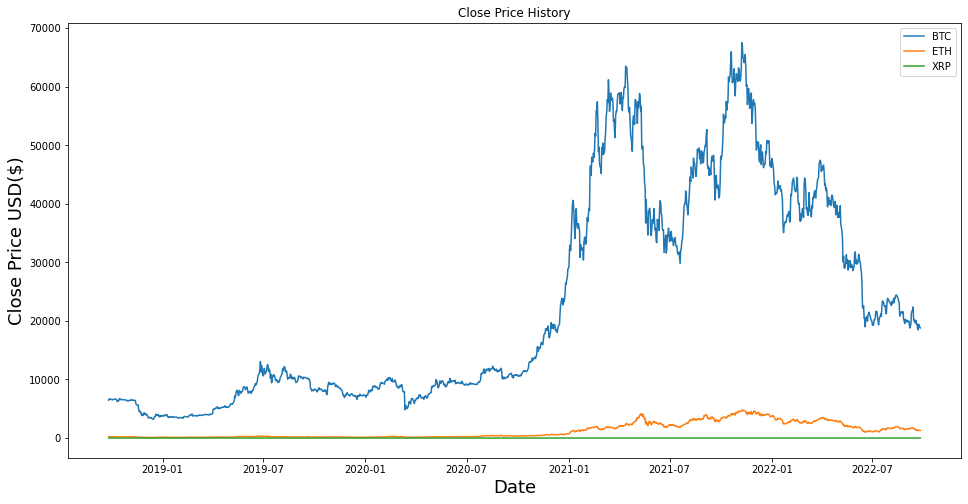

In [8]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(btc_df['Price'])
plt.plot(eth_df['Price'])
plt.plot(xrp_df['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.legend(['BTC', 'ETH', 'XRP'])
plt.show()

In [6]:
nbtc_df, neth_df, nxrp_df = btc_df.copy(), eth_df.copy(), xrp_df.copy()
nbtc_df['AssetName'], neth_df['AssetName'], nxrp_df['AssetName'] = 'BTC', 'ETH', 'XRP'
#nbtc_df['AssetID'], neth_df['AssetID'], nxrp_df['AssetID'] = 1, 2, 3

crypto_df = pd.concat([nbtc_df, neth_df, nxrp_df])

In [67]:
crypto_df.head()

,Price,AssetName
Date,,
2022-09-25,18803.2,BTC
2022-09-24,18925.2,BTC
2022-09-23,19293.5,BTC
2022-09-22,19404.0,BTC
2022-09-21,18489.0,BTC


In [7]:
crypto_df.index = crypto_df.index.astype('int64') // 10**9

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [8]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [9]:
# create dataframe with returns for all assets
all_assets = pd.DataFrame([])
for asset_name in ['BTC', 'ETH', 'XRP']:
  asset = crypto_df[crypto_df["AssetName"]==asset_name]
  #asset = asset.loc[totimestamp('09/26/2018'):totimestamp('09/25/2022')]
  print(asset.head())
  #asset = asset.reindex(range(asset.index[-1], asset.index[0]+86400*30, 86400*30), method='pad')
  lret = log_return(asset.Price)[1:]
  all_assets = all_assets.join(lret, rsuffix=asset_name, how="outer")

              Price AssetName
Date                         
1664064000  18803.2       BTC
1663977600  18925.2       BTC
1663891200  19293.5       BTC
1663804800  19404.0       BTC
1663718400  18489.0       BTC
              Price AssetName
Date                         
1664064000  1294.26       ETH
1663977600  1317.00       ETH
1663891200  1327.96       ETH
1663804800  1326.44       ETH
1663718400  1247.74       ETH
              Price AssetName
Date                         
1664064000  0.49202       XRP
1663977600  0.48781       XRP
1663891200  0.50768       XRP
1663804800  0.48522       XRP
1663718400  0.39403       XRP


In [10]:
all_assets.columns = ['PriceBTC', 'PriceETH', 'PriceXRP']

In [11]:
corr = all_assets.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,PriceBTC,PriceETH,PriceXRP
PriceBTC,1.00,0.84,0.62
PriceETH,0.84,1.00,0.67
PriceXRP,0.62,0.67,1.00


In [220]:
btc_df = btc_df.iloc[::-1]

# LSTM

In [221]:
btc_df.head()

,Price
Date,
2018-09-26,6468.1
2018-09-27,6689.2
2018-09-28,6636.0
2018-09-29,6603.9
2018-09-30,6635.2


**Note:** Comparing to other models, LSTM need to slice the train data first, in our case the train data was sliced into 7 days window.
LSTM will decide if some windows need to be forgotten, which means it may not fully leverage all train data.

In [148]:
def norm_train_test_split(data, time_step):
    # convert to numpy array
    dataset = data.values
    # get the number of rows to train the model on
    train_data_len = math.ceil(len(dataset) * .8)

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)   
    
    train_data = scaled_data[0:train_data_len, :]
    # test_data = scaled_data[train_data_len-60:, :], we need -60 to get the values for predicting front rows in test set
    # split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
        
    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    # create a new array containing scaled values from index 980 to 1040
    test_data = scaled_data[train_data_len-time_step:, :]
    x_test = []
    y_test = dataset[train_data_len:, :] # not scaled but normal values in dataset
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test, y_test

In [149]:
x_train, y_train, x_test, y_test = norm_train_test_split(btc_df, 7)

In [150]:
# reshape the date, LSTM expects the data to be 3-dimensional, number of sample, number of time steps, number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# convert to np and reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# build the LSTM model
model = Sequential()
#model.add(LSTM(32, return_sequences=False, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(30, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(.2)) # Fraction of the input units to drop
model.add(LSTM(50, return_sequences=False))
#model.add(Dropout(.2))
model.add(Dense(25))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')   

In [162]:
model = Sequential()
for i in range(1):
    model.add(
        LSTM(
            units=20,
            dropout=0,
            activation='sigmoid',
            return_sequences=True, 
            input_shape = (x_train.shape[1], 1))
        )
model.add(
    LSTM(
        units=40,
        dropout=0.05,
        activation='sigmoid',
        return_sequences=False
    )
)

model.add(Dense(25))
model.add(Dense(1))

# We compile our model with a sampled learning rate.
adam = optimizers.Adam(
    learning_rate=0.002
)
model.compile(
    optimizer=adam, 
    loss='mean_squared_error'
) 

In [163]:
# train the mode
early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                               patience = 5)
model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop])

Epoch 1/100
10/10 [==============================] - 2s 7ms/step - loss: 0.1008
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0904
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0833
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0823
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0807
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0846
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0751
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0722
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0663
Epoch 11/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0580
Epoch 12/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0497
Epoch 13/100
10/10 [=================

In [154]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 7, 20)             1760      
                                                                 
 lstm_11 (LSTM)              (None, 40)                9760      
                                                                 
 dense_10 (Dense)            (None, 25)                1025      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 12,571
Trainable params: 12,571
Non-trainable params: 0
_________________________________________________________________


In [164]:
# prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 0s 1ms/step


In [165]:
# evaluate, get the RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1001.0498983304794

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


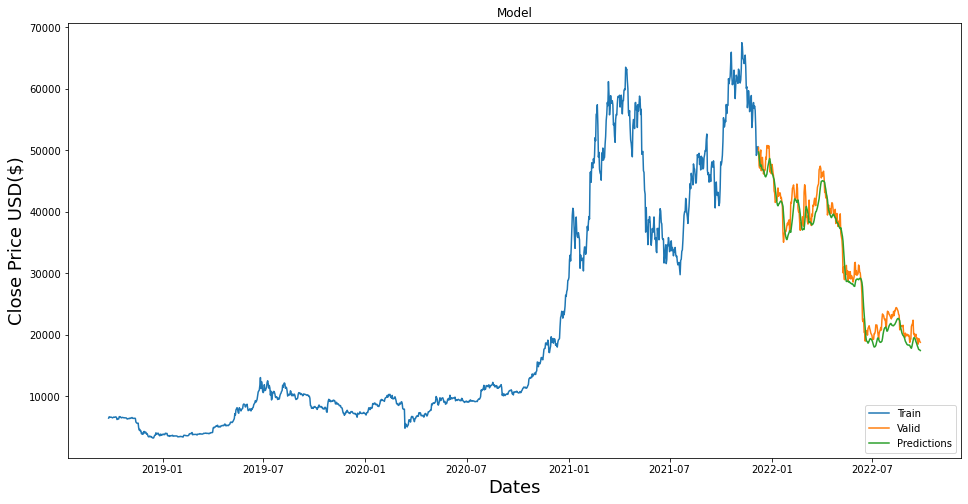

In [166]:
# plot
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predections'] = predictions
# visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predections']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [108]:
valid.tail(10)

,Price,Predections
Date,,
2022-09-16,19802.4,21995.279297
2022-09-17,20113.5,21700.080078
2022-09-18,19418.8,21474.802734
2022-09-19,19538.9,21122.419922
2022-09-20,18872.4,20832.789062
2022-09-21,18489.0,20604.962891
2022-09-22,19404.0,20324.210938
2022-09-23,19293.5,20297.117188
2022-09-24,18925.2,20241.548828


In [79]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    global x_train, y_train, x_test, y_test
    
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            LSTM(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True, 
                input_shape = (x_train.shape[1], 1)
            )
        )
    model.add(
        LSTM(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(25))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 

    model.fit(
        x_train, 
        y_train,
        batch_size=128, 
        epochs=100
    )

#     Evaluate the model accuracy on the validation set.
#     score = model.evaluate(x_test, y_test, verbose=0)
#     return score
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    score = np.sqrt(np.mean(predictions - y_test)**2)
    return score


if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2022-10-18 00:09:42,952] A new study created in memory with name: no-name-9657f187-a9df-4920-bab4-654407a8de8c


Epoch 1/100
8/8 [==============================] - 2s 7ms/step - loss: 0.0576
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0333
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 11/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 12/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 13/100
8/8 [==============================] - 0s 7ms/st

[I 2022-10-18 00:09:51,968] Trial 0 finished with value: 946.9882007778966 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0006128705453381029}. Best is trial 0 with value: 946.9882007778966.


Epoch 1/100
8/8 [==============================] - 2s 23ms/step - loss: 0.1497
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0582
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0458
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0491
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0457
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0439
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0443
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0439
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0440
Epoch 10/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0439
Epoch 11/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0439
Epoch 12/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0439
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:10:13,410] Trial 1 finished with value: 32691.496769380363 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.2, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 0.0001774929885526876}. Best is trial 0 with value: 946.9882007778966.


Epoch 1/100
8/8 [==============================] - 2s 10ms/step - loss: 0.0665
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0581
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0506
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0465
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0444
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0440
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0428
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0427
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0420
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0425
Epoch 11/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0410
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0395
Epoch 13/100
8/8 [==============================] 

[I 2022-10-18 00:10:23,411] Trial 2 finished with value: 37.613554519849984 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0024773330429161407}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 3s 12ms/step - loss: 1.2056
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0871
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0554
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0473
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0482
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0448
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0454
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0446
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0451
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0445
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0439
Epoch 12/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0444
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:10:35,926] Trial 3 finished with value: 451.04434683476364 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.02817549278531706}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 5s 32ms/step - loss: 0.0672
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0629
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0591
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0555
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0520
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0489
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0455
Epoch 8/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0425
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0395
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0365
Epoch 11/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0342
Epoch 12/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0315
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:11:07,521] Trial 4 finished with value: 881.0687818535405 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 4.956059194842363e-05}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 3s 22ms/step - loss: 0.2525
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1629
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1011
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0663
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0505
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0452
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0448
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0450
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0439
Epoch 10/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0444
Epoch 11/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0451
Epoch 12/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0446
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:11:28,004] Trial 5 finished with value: 33465.385629861856 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.2, 'activation2': 'sigmoid', 'adam_lr': 9.014842242884066e-05}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 6ms/step - loss: 0.4555
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4464
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4370
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4278
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4187
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 0.4090
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3996
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3911
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3831
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3740
Epoch 11/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3665
Epoch 12/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3573
Epoch 13/100
8/8 [==============================] - 0s 5ms/st

[I 2022-10-18 00:11:34,243] Trial 6 finished with value: 41473.460141999734 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 1.394106956525273e-05}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 3s 17ms/step - loss: 0.0525
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0477
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0453
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0451
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0436
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0440
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0442
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0436
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0438
Epoch 10/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0434
Epoch 11/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0439
Epoch 12/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0434
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:11:52,242] Trial 7 finished with value: 1192.5970745037555 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0006242589573339467}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 7ms/step - loss: 0.0942
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0502
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0416
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0396
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0379
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0357
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0319
Epoch 11/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0264
Epoch 12/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 13/100
8/8 [==============================] - 0s 5ms/st

[I 2022-10-18 00:11:59,505] Trial 8 finished with value: 979.8152863465663 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.0042838810979755676}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 3s 27ms/step - loss: 0.1093
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0552
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0481
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0450
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0442
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0438
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0437
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0434
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0433
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0432
Epoch 11/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0429
Epoch 12/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0426
Epoch 13/100
8/8 [==============================]

8/8 [==============================] - 0s 27ms/step - loss: 4.8128e-04
Epoch 100/100
8/8 [==============================] - 0s 3ms/step


[I 2022-10-18 00:12:25,213] Trial 9 finished with value: 2010.7753353004289 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.003307608506717756}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 8ms/step - loss: 21.8053
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1724
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6261
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1504
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1008
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0887
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0482
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0529
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0444
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0460
Epoch 11/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0446
Epoch 12/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0444
Epoch 13/100
8/8 [==============================] - 0s 8ms/s

[I 2022-10-18 00:12:34,139] Trial 10 finished with value: 33921.70406467945 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0902065986238827}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 13ms/step - loss: 12.3877
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.3141
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4352
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0929
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0551
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0637
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0478
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0448
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0436
Epoch 12/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0437
Epoch 13/100
8/8 [==============================

[I 2022-10-18 00:12:46,336] Trial 11 finished with value: 970.0912218347637 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.05412827564434091}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 6ms/step - loss: 0.3762
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0578
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0561
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0476
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0446
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0437
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0437
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0436
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0432
Epoch 11/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0430
Epoch 12/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0425
Epoch 13/100
8/8 [==============================] - 0s 6ms/st

8/8 [==============================] - 0s 1ms/step


[I 2022-10-18 00:12:53,135] Trial 12 finished with value: 281.100015088519 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.020502353485666612}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 12ms/step - loss: 0.9603
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1882
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0695
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0844
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0470
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0510
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0442
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0450
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0435
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0435
Epoch 11/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 12/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0432
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:13:03,310] Trial 13 finished with value: 670.56578929721 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.012277126375926576}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 6ms/step - loss: 0.1622
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0618
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0477
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0463
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 11/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 12/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 13/100
8/8 [==============================] - 0s 5ms/st

[I 2022-10-18 00:13:10,365] Trial 14 finished with value: 811.191409603004 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.004276519886164329}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 11ms/step - loss: 0.4353
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1134
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0452
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0145
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 8.9801e-04
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 8.0472e-04
Epoch 13/100
8/8 [=======================

8/8 [==============================] - 0s 11ms/step - loss: 3.0049e-04
Epoch 100/100
8/8 [==============================] - 0s 2ms/step


[I 2022-10-18 00:13:21,813] Trial 15 finished with value: 836.3760444608371 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.01128777485857886}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 11ms/step - loss: 0.0830
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0562
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0488
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0461
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0444
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0435
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0435
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0430
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0434
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0431
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0428
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0424
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:13:32,886] Trial 16 finished with value: 1159.6003084763947 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0015699389641028894}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 11ms/step - loss: 1.6859
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1110
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1079
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0515
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0498
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0493
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0441
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0444
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0434
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0431
Epoch 13/100
8/8 [==============================]

[I 2022-10-18 00:13:44,342] Trial 17 finished with value: 1102.9326582618023 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.017272476669726346}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 6ms/step - loss: 0.0656
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0425
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0291
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0154
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 9.6059e-04
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 8.3745e-04
Epoch 11/100
8/8 [==============================] - 0s 5ms/step - loss: 6.7668e-04
Epoch 12/100
8/8 [==============================] - 0s 6ms/step - loss: 7.2764e-04
Epoch 13/100
8/8 [===========================

8/8 [==============================] - 0s 2ms/step


[I 2022-10-18 00:13:51,392] Trial 18 finished with value: 1496.5728976663088 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0018721079709844335}. Best is trial 2 with value: 37.613554519849984.


Epoch 1/100
8/8 [==============================] - 2s 10ms/step - loss: 0.4483
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1483
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0747
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0513
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0488
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0466
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0437
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0427
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0425
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0422
Epoch 11/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0416
Epoch 12/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0412
Epoch 13/100
8/8 [==============================] - 0s 9ms/

8/8 [==============================] - 0s 2ms/step


[I 2022-10-18 00:14:01,111] Trial 19 finished with value: 846.7020302440984 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.007988945285930834}. Best is trial 2 with value: 37.613554519849984.


Number of finished trials: 20
Best trial:
  Value: 37.613554519849984
  Params: 
    n_layers: 1
    unit_cnt1: 20
    dropout1: 0
    activation1: sigmoid
    unit_cnt2: 40
    dropout2: 0.05
    activation2: sigmoid
    adam_lr: 0.0024773330429161407


8/8 [==============================] - 0s 2ms/step
cv_rmse= 7033.139002499338


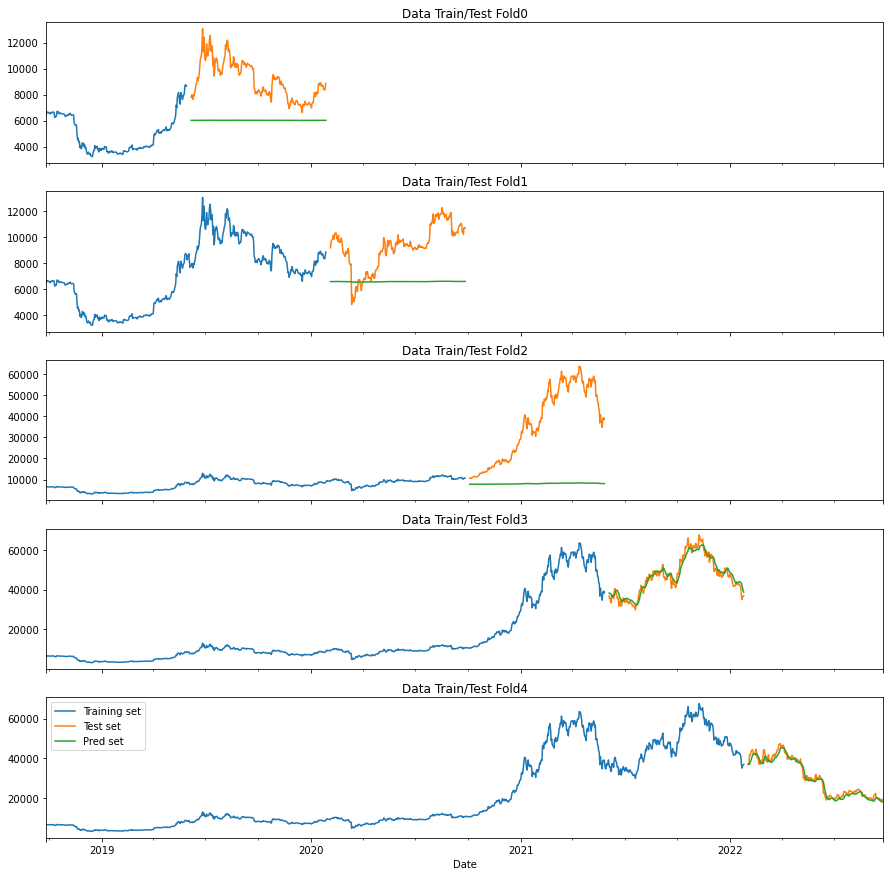

In [222]:
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train = []
    y_train = []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    

    model = Sequential()
    for i in range(1):
        model.add(
            LSTM(
                units=20,
                dropout=0,
                activation='sigmoid',
                return_sequences=True, 
                input_shape = (x_train.shape[1], 1))
            )
    model.add(
        LSTM(
            units=40,
            dropout=0.05,
            activation='sigmoid',
            return_sequences=False
        )
    )

    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(
        learning_rate=0.002
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 5)
    model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

# BiLSTM

In [167]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [88]:
rmse_results = []
for _ in range(5):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(35, return_sequences=True), 
              input_shape=(x_train.shape[1], 1)))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = 35)))
    model.add(Dense(32))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 3)
    model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks = [early_stop])
    
    # prediction
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    # evaluate, get the RMSE
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    rmse_results.append(rmse)

Epoch 1/100
5/5 [==============================] - 4s 17ms/step - loss: 0.0954
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0186
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0205
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0056
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0023
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0013
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0012
Epoch 11/100
5/5 [==============================] - 0s 16ms/step - loss: 9.3043e-04
Epoch 12/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0010
Epoch 13/100
5/5 [===========================

5/5 [==============================] - 0s 19ms/step - loss: 7.4262e-04
Epoch 38/100
5/5 [==============================] - 0s 19ms/step - loss: 7.3870e-04
Epoch 39/100
5/5 [==============================] - 0s 19ms/step - loss: 7.3989e-04
Epoch 40/100
5/5 [==============================] - 0s 20ms/step - loss: 7.3032e-04
Epoch 41/100
5/5 [==============================] - 0s 19ms/step - loss: 7.3151e-04
Epoch 42/100
5/5 [==============================] - 0s 19ms/step - loss: 7.3352e-04
Epoch 43/100
5/5 [==============================] - 0s 20ms/step - loss: 7.2621e-04
Epoch 44/100
5/5 [==============================] - 0s 19ms/step - loss: 7.2105e-04
Epoch 45/100
5/5 [==============================] - 0s 19ms/step - loss: 7.2324e-04
Epoch 46/100
5/5 [==============================] - 0s 19ms/step - loss: 7.1751e-04
Epoch 47/100
5/5 [==============================] - 0s 19ms/step - loss: 7.1418e-04
Epoch 48/100
5/5 [==============================] - 0s 19ms/step - loss: 7.1439e-04
Epoch

In [89]:
print(rmse_results)
print(np.mean(rmse_results))

[1046.6941085188357, 1055.724850171233, 2.171038901969153, 616.4199352525685, 335.25828071489724]
611.2536427119006


# GRU

In [99]:
rmse_results = []
for _ in range(5):
    print('iteration:', (_+1))
    print('----'*10)
    model = Sequential()
    # Input layer
    model.add(GRU(30, return_sequences = True, input_shape = [x_train.shape[1], 1]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(30)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 3)
    model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks = [early_stop])
    
    # prediction
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    # evaluate, get the RMSE
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    rmse_results.append(rmse)

iteration: 1
----------------------------------------
Epoch 1/100
5/5 [==============================] - 2s 11ms/step - loss: 0.0854
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0228
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0046
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0044
Epoch 10/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 11/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 12/100
5/5 [==============================] - 0s 11ms/step - loss: 0.

In [100]:
print(rmse_results)
print(np.mean(rmse_results))

[314.7626284246575, 469.1290333369007, 455.82302145761986, 42.42768086472605, 961.3072024828767]
448.6899133133562


# XGBoost

In [111]:
def load_data():
    btc_df = pd.read_csv('BTCData.csv')
    eth_df = pd.read_csv('ETHData.csv')
    xrp_df = pd.read_csv('XRPData.csv')

    btc_df = btc_df.replace(',','', regex=True)
    btc_df = btc_df[['Price', 'Date']]
    btc_df['Date']= pd.to_datetime(btc_df['Date'])
    btc_df = btc_df.set_index("Date")
    btc_df['Price'] = pd.to_numeric(btc_df['Price'],errors='coerce')
    btc_df = btc_df[::-1]
    
    return btc_df

In [112]:
btc_df = load_data()

In [117]:
def train_test_split(data, time_step):
    # convert to numpy array
    dataset = data.values
    # get the number of rows to train the model on
    train_data_len = math.ceil(len(dataset) * .8)
    
    train_data = dataset[0:train_data_len, :]
    # test_data = data[train_data_len-60:, :], we need -60 to get the values for predicting front rows in test set
    # split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
        
    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    # create a new array containing scaled values from index 980 to 1040
    test_data = dataset[train_data_len-time_step:, :]
    x_test = []
    y_test = dataset[train_data_len:, :]
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test, y_test

In [118]:
x_train, y_train, x_test, y_test = train_test_split(btc_df, 7)

In [143]:
from xgboost import XGBRegressor
def objective(trial):
    xgb_params = {
        "n_estimators":trial.suggest_categorical("n_estimators", [400, 500, 600, 800, 1000]),
        "max_depth":trial.suggest_int("max_depth", 3, 10), 
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 6),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.05, 0.1, 1, 2, 3])
    }
    model = XGBRegressor(**xgb_params)
    model.fit(x_train, y_train, verbose=False)
    
    predictions = model.predict(x_test)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return rmse

In [144]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-10-19 00:02:01,088] A new study created in memory with name: no-name-0dd8218d-b9fe-41ac-9e4b-6f7a3f2b7472
[I 2022-10-19 00:02:01,537] Trial 0 finished with value: 1133.337743471746 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.2, 'reg_lambda': 3}. Best is trial 0 with value: 1133.337743471746.
[I 2022-10-19 00:02:02,292] Trial 1 finished with value: 937.9739873180646 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.4, 'reg_lambda': 0.05}. Best is trial 1 with value: 937.9739873180646.
[I 2022-10-19 00:02:02,617] Trial 2 finished with value: 1055.2277263484584 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.1, 'reg_lambda': 0.05}. Best is trial 1 with value: 937.9739873180646.
[I 2022-10-19 00:02:03,031] Trial 3 finished with value: 1107.8458703446056 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.3, 'reg_lambda': 3}. 

Number of finished trials: 30
Best trial: {'n_estimators': 800, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.4, 'reg_lambda': 0.05}


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cv_rmse= 5525.139925516419


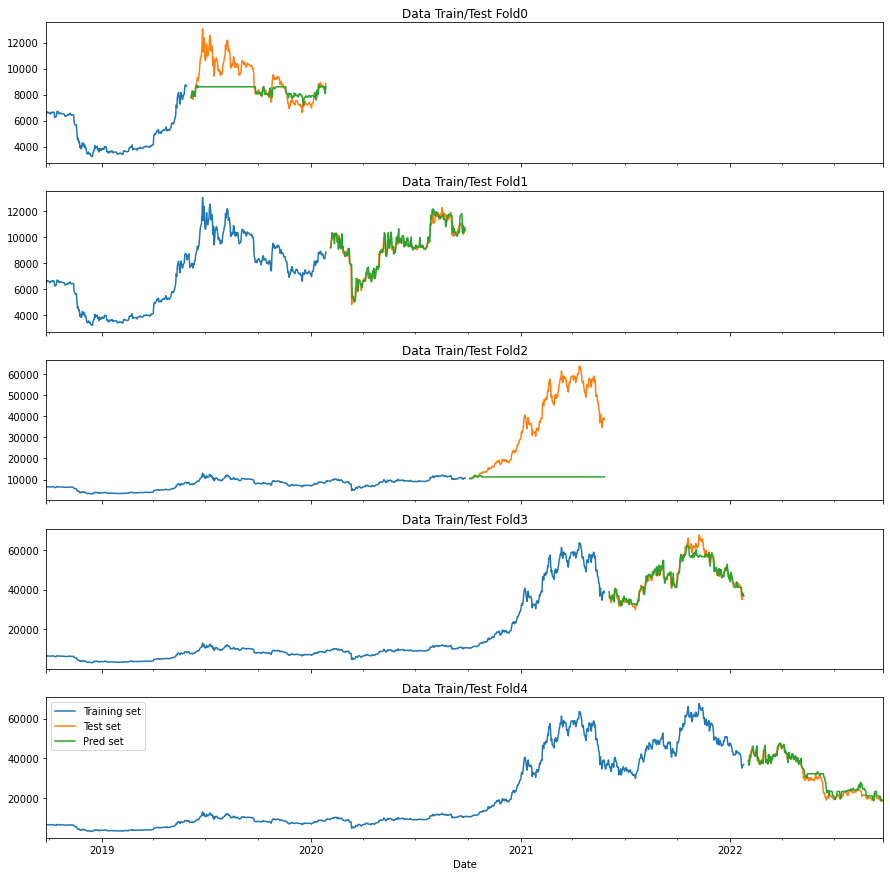

In [200]:
Best_trial = {'n_estimators': 800, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.4, 'reg_lambda': 0.05}
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(btc_df.iloc[train_idx])
    test_data = np.array(btc_df.iloc[test_idx])
    
    train_data_len = len(train_data)
    x_train = []
    y_train = []
    
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])

    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)

    model = XGBRegressor(**Best_trial)
    model.fit(x_train, y_train, verbose=False)

    predictions = model.predict(x_test)
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


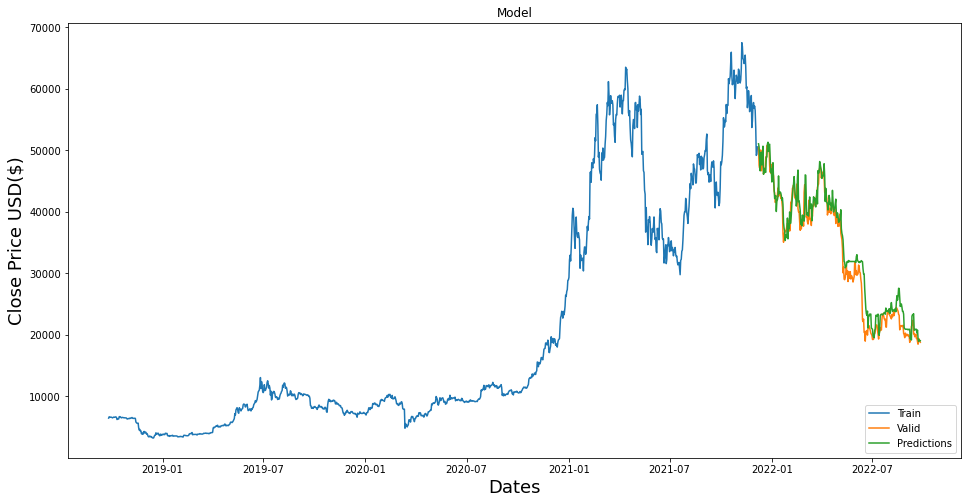

In [146]:
# plot
train = btc_df[:train_data_len]
valid = btc_df[train_data_len:]
valid['Predections'] = predictions
# visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predections']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

# ARIMA

In [28]:
btc_df.head()

,Price
Date,
2018-09-26,6468.1
2018-09-27,6689.2
2018-09-28,6636.0
2018-09-29,6603.9
2018-09-30,6635.2


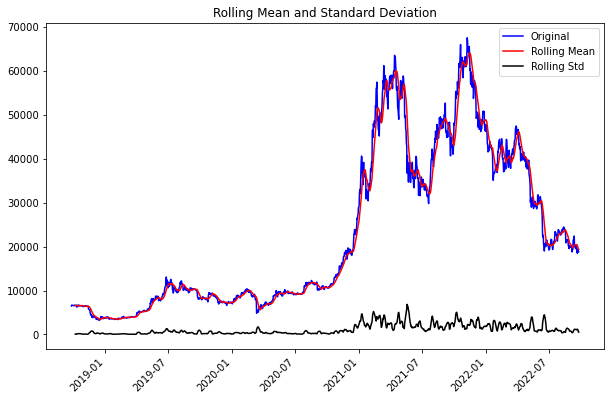

Results of dickey fuller test
Test Statistics                  -1.353307
p-value                           0.604446
No. of lags used                 12.000000
Number of observations used    1448.000000
critical value (1%)              -3.434874
critical value (5%)              -2.863538
critical value (10%)             -2.567834
dtype: float64


In [31]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # rolling mean of 12 samples
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(btc_df)

We can’t rule out the Null hypothesis(The series has a unit root (value of a =1), i.e. , the series is said to be non-stationary) because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear. **Seasonality and trend may need to be separated from our series before we can undertake a time series analysis**. This approach will cause the resulting series to become stagnant.

<Figure size 720x432 with 0 Axes>

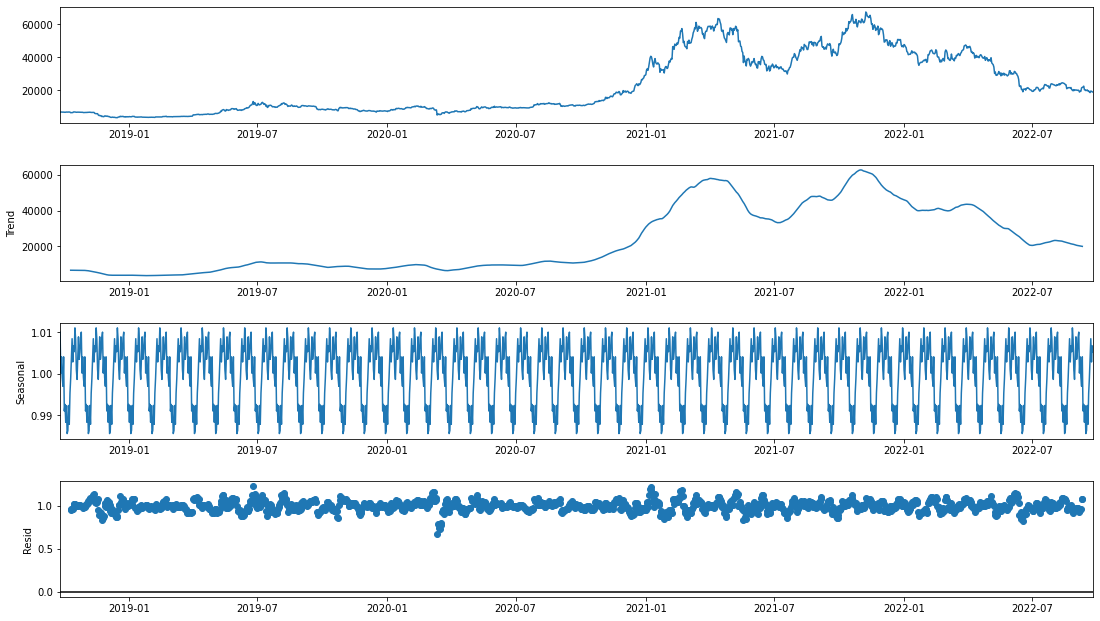

In [32]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(btc_df, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


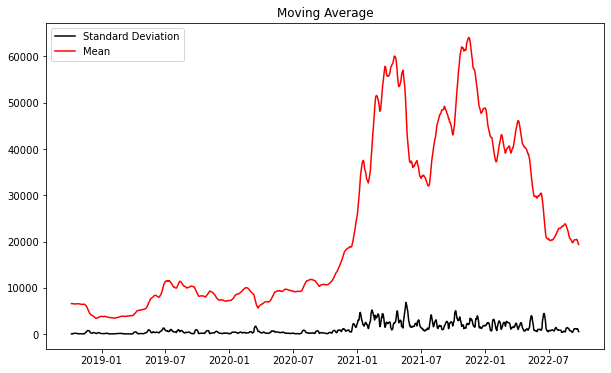

In [53]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(btc_df)
df_log = btc_df
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

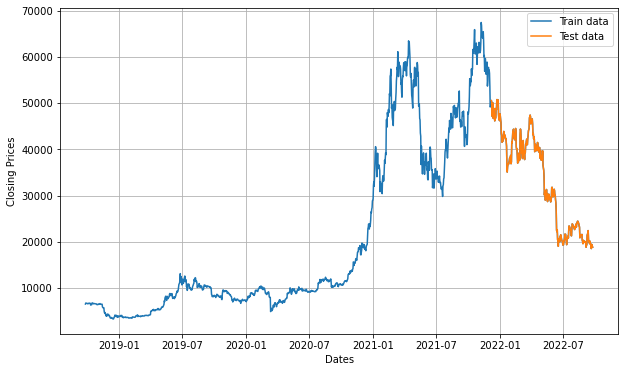

In [54]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19646.933, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19646.090, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19646.145, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19646.326, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19648.042, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19648.066, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19650.043, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19645.631, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19647.561, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19647.573, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19645.688, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19649.560, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.605 seconds
                               SARIMAX Results                              

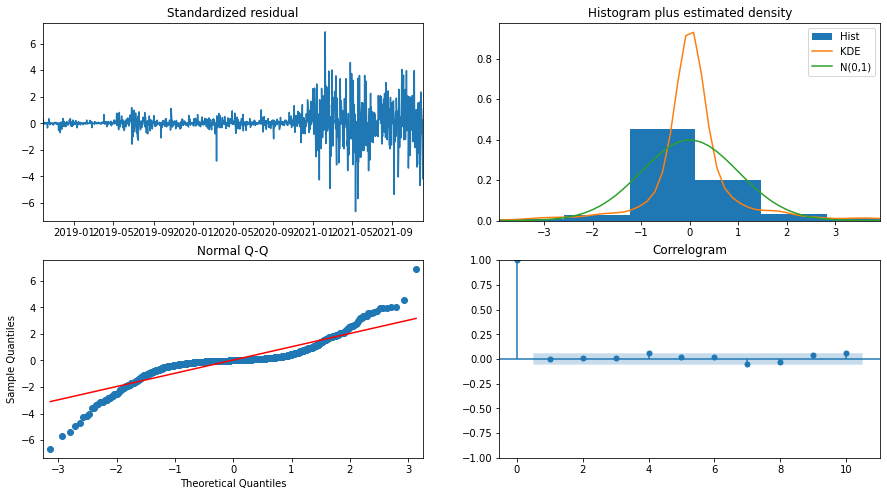

In [39]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [57]:
train_data, test_data = train_data.values, test_data.values
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = np.sqrt(mean_squared_error(test_data, model_predictions))
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1184.6455243482496


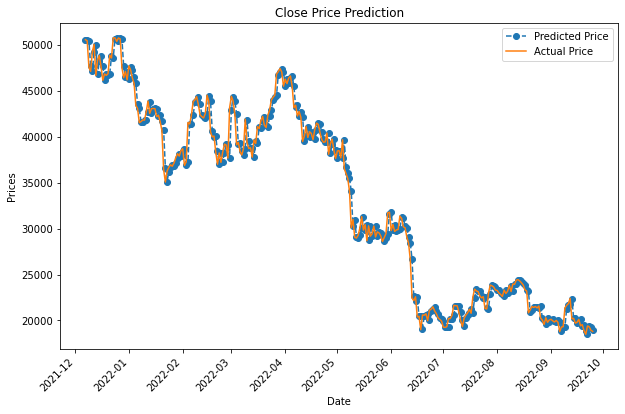

In [55]:
test_set_range = df_log[int(len(df_log)*0.8):].index
plt.figure(figsize=(10,6))
plt.plot(test_set_range, model_predictions, marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, label='Actual Price')
plt.title('Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [46]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1168
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9820.816
Date:                Wed, 12 Oct 2022   AIC                          19645.631
Time:                        15:54:17   BIC                          19655.756
Sample:                             0   HQIC                         19649.450
                               - 1168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.019     -2.490      0.013      -0.085      -0.010
sigma2      1.195e+06   2.07e+04     57.630      0.000    1.15e+06    1.24e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

# Facebook Prophet

In [12]:
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import datetime as dt
pd.core.common.is_list_like = pd.api.types.is_list_like
import seaborn as sns
import matplotlib.dates as mdates

In [18]:
data = btc_df.reset_index()
data=data[["Date","Price"]]
data=data.rename(columns={"Date": "ds", "Price": "y"})

In [29]:
train_data_pro, test_data_pro = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [30]:
m = Prophet()
m.fit(train_data_pro)
future = m.make_future_dataframe(periods = test_data_pro.shape[0])
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1456,2022-09-21,71439.271245,41966.425294,103206.363811
1457,2022-09-22,71411.962225,42099.555316,104688.792613
1458,2022-09-23,71551.546230,42109.956743,104852.922606
1459,2022-09-24,71622.946107,42271.442465,104805.119789
1460,2022-09-25,71720.196979,42687.608484,104976.014617


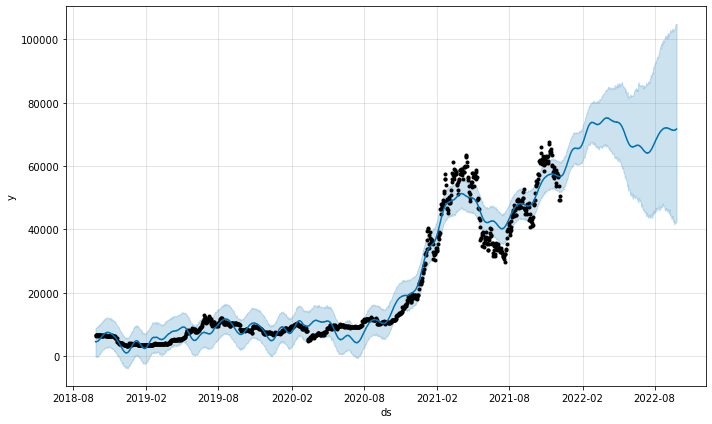

In [31]:
fig1 = m.plot(forecast)

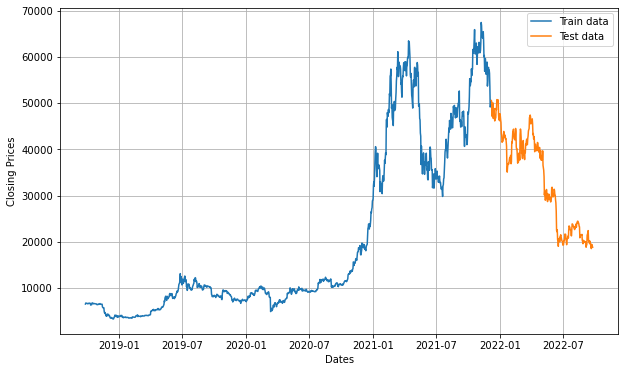

In [28]:
train_data, test_data = btc_df[:int(len(btc_df)*0.8)], btc_df[int(len(btc_df)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

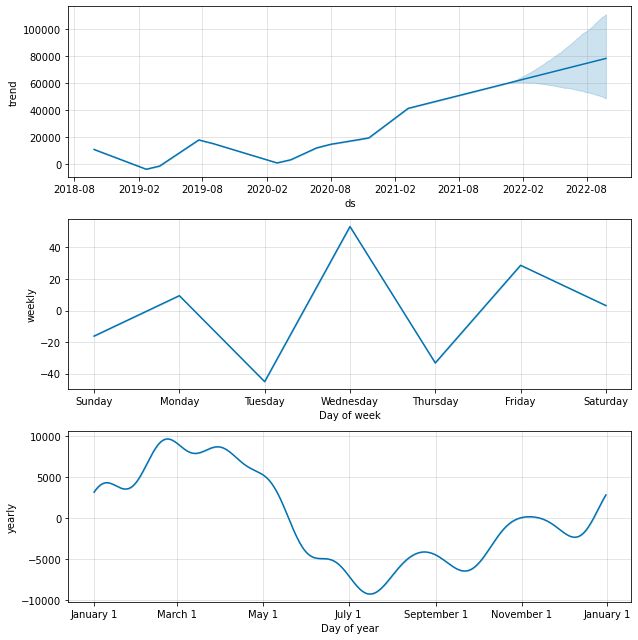

In [38]:
fig2 = m.plot_components(forecast)

In [36]:
rmse = np.sqrt(np.mean((forecast['yhat'] - test_data_pro['y']) ** 2))
print(rmse)

37481.99733585797
